# Preparation

In [20]:
import glob
import os
import random

import graphviz
import matplotlib.pyplot as plt
import nilearn.image as nimg
import numpy as np
import pandas as pd
import seaborn as sb
from IPython.display import IFrame
from nilearn import plotting
from sklearn import tree
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split

from aafm.sample_service import SampleService
from core.postprocess_service import PostprocessService
from aafm.AAFM_service import AAFMService
from matplotlib.colors import LinearSegmentedColormap

In [21]:
# load global vars
postproc_srv = PostprocessService()
sample_srv = SampleService()
aafm_srv = AAFMService()
basedir = "/home/ymerel/storage/results/auditory"
mean_path = os.path.join(basedir, 'mean_result.nii')
df_path = os.path.join(basedir, 'dataset.csv')
corr_path = os.path.join(basedir, 'correlations.csv')
ids = []
results = []
paths = glob.glob(os.path.join(basedir, '*/'), recursive=True)
for path in paths:
    ids.append(os.path.basename(os.path.dirname(path)))
    results.append(os.path.join(path, '_subject_id_01', 'result.nii'))

# Load dataset
90 features + config hash (id) + correlation from ref + correlation from mean

In [22]:
# Mount group storage
!sshfs -o reconnect,ServerAliveInterval=120,ServerAliveCountMax=3 rennes.g5k:/srv/storage/empenn@storage2.rennes.grid5000.fr/private/ymerel /home/ymerel/storage
# load correlations
correlations = pd.read_csv(corr_path, delimiter=';')

fusermount3: failed to access mountpoint /home/ymerel/storage: Permission denied


In [23]:
# write extended dataset (with mean of correlations, 10 random ref)
# Choose 10 random correlations as refs
def get_extended_dataset():
    unique_values = [value for value in correlations['source'].unique() if value not in ['ref', 'mean']]
    random_refs = random.sample(list(unique_values), 10)
    extended_dataset = pd.read_csv(df_path, delimiter=';')
    for ref in random_refs:
        print(f"Fetching correlations for random ref [{ref}]")
        for index, row in extended_dataset.iterrows():
            id_value = row['id']
            correlation = correlations.loc[
            (correlations['source'] == id_value) &
            (correlations['target'] == ref), 'correlation'].values[0]
            extended_dataset.at[index, f'from_{ref}'] = correlation
    print(f"Calculating mean of correlations for each config")
    for index, row in extended_dataset.iterrows():
            id_value = row['id']
            if id_value == 'ref' or id_value == 'mean':
                continue
            values = correlations.loc[
            (correlations['source'] == id_value) & (correlations['target'] != id_value) & (correlations['target'] != 'ref') & (correlations['target'] != 'mean'), 'correlation'].values
            extended_dataset.at[index, f'mean_corr'] =  sum(values) / len(values)
    # write dataset
    extended_dataset.to_csv(os.path.join(basedir, 'extended_dataset.csv'), index=False, sep=';')

# get_extended_dataset()

In [24]:
dataset = pd.read_csv(os.path.join(basedir, 'extended_dataset.csv'), delimiter=';')
corr_fields = [col for col in dataset.columns if col.startswith('from_')]
corr_fields.append('mean_corr')
dataset.head()

,spatial_smoothing/fwhm/12,spatial_smoothing/tool/spm,slice_timing_correction/ref_slice/middle,signal_modeling/hrf/temporal_dispersion_derivs,spatial_normalization/bias_fwhm/130,spatial_normalization/template,signal_modeling/hrf,signal_modeling/nuisance_regressors/motion/18,spatial_smoothing/fwhm/2,coregistration/cost_function/mutual_information,...,from_1bd27c273e9f4d9eec9254015501cc8d1eeb109a6cc6ff25c55bfc81f210bb23,from_e2981f97fc870a8fc8a66d9a40c3cc8dcb21be746ad83ecbcc320c8fe4298a73,from_bdab21629030923da17e248d7689fc21eb1abea0d889d3b44c67b4baf6a07de5,from_6363ceb4ad5221e2fd865e8ba9181032905c33814f925c2e960adcd5354485e4,from_2566dc31e9fbea6d892a21f56ecb62ff9df850705b65b17754f772d13f060284,from_6b4189bcd2f407a23e0ebc2d14de55529eaab1b0f5a612ba46b79d019b03cc46,from_c475f858fc2881ef01d1d4b705346000d23d56508ee89dcbf18e173daf48de57,from_5b935ba44056218711fe041d9e5000904a788b010f7c12dd70041a2e5cc4e135,from_05a74cdcbd5faa976b866eec5a083de5e3945cc85a8971c44863127732e7026d,mean_corr
0,False,True,False,True,False,True,True,False,True,True,...,0.583359,0.585454,0.467426,0.584460,0.640727,0.422977,0.416205,0.281066,0.813123,0.372960
1,False,True,True,False,False,True,True,False,False,False,...,0.461472,0.464436,0.624274,0.162757,0.311513,0.478202,0.595410,0.584970,0.375992,0.448391
2,False,True,True,True,False,True,True,False,True,False,...,0.046111,0.047896,0.054734,0.017863,0.035509,0.080146,0.109115,0.047371,0.073594,0.162453
3,True,True,False,True,False,True,True,False,False,False,...,0.357359,0.357296,0.454988,0.160300,0.258135,0.832560,0.765298,0.533354,0.457524,0.393672
4,False,True,True,True,False,True,True,True,True,False,...,0.046111,0.047896,0.054734,0.017863,0.035509,0.080146,0.109115,0.047371,0.073594,0.162453


# Features repartition
Check features repartition for all configurations vs sample

Retrieved all [27648] configurations from [/home/ymerel/fmri-feature-model/model/uvl/full_pipeline.uvl]


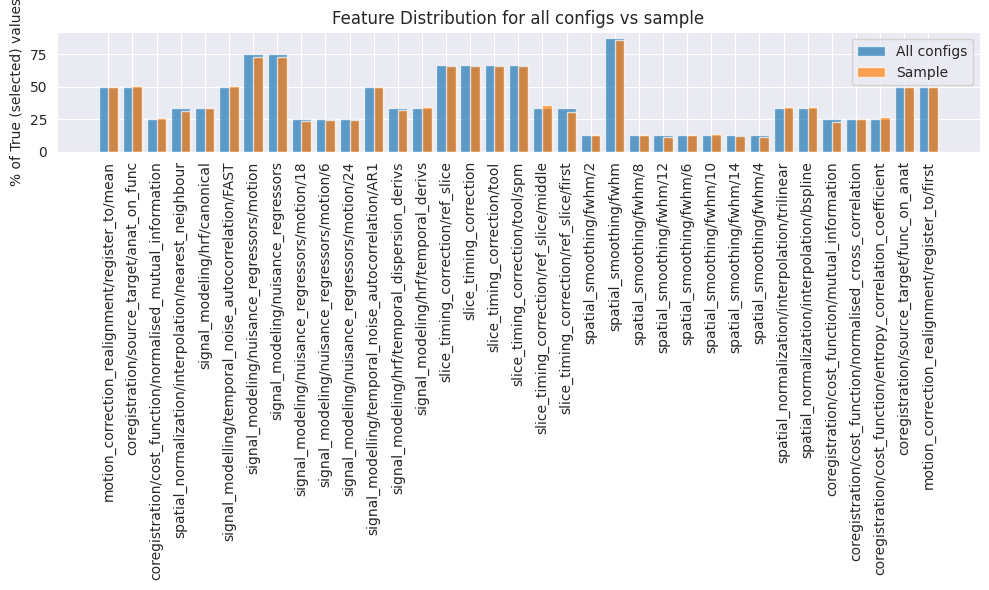

In [25]:
pd.set_option('future.no_silent_downcasting', True)
full = pd.DataFrame(sample_srv.get_all_configs()).fillna(False).astype(bool)
full_rep = full.mean() * 100
full_rep = full_rep[(full_rep > 0) & (full_rep < 100)]
ignored = corr_fields.copy()
ignored.append('id')
sample_rep = dataset.drop(columns=ignored).mean() * 100
sample_rep = sample_rep[(full_rep > 0) & (sample_rep < 100)]
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the percentages for df1
ax.bar(full_rep.index, full_rep, alpha=0.7, label='All configs')

# Plot the percentages for df2
ax.bar(sample_rep.index, sample_rep, alpha=0.7, label='Sample', align='edge', width=0.4)

# Add labels and title
ax.set_ylabel('% of True (selected) values')
ax.set_title('Feature Distribution for all configs vs sample')
ax.legend()

# Show plot
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Ref correlations repartition

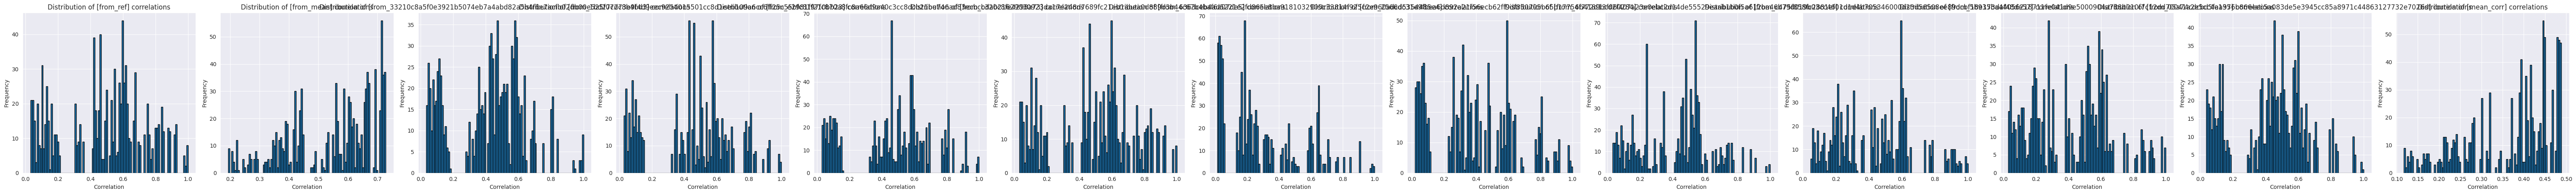

In [26]:
num_plots = len(corr_fields)
fig, axes = plt.subplots(ncols=num_plots, figsize=(5 * num_plots, 5))

for i, corr in enumerate(corr_fields):
    axes[i].hist(dataset[corr], bins=100, edgecolor='black')
    axes[i].set_title(f'Distribution of [{corr}] correlations')
    axes[i].set_xlabel('Correlation')
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

# Stats maps QC
For `from_ref`, `from_mean`, `mean_corr` correlations, display the 3 "worst" and "best" correlated results

[from_ref] 3 worst correlated maps


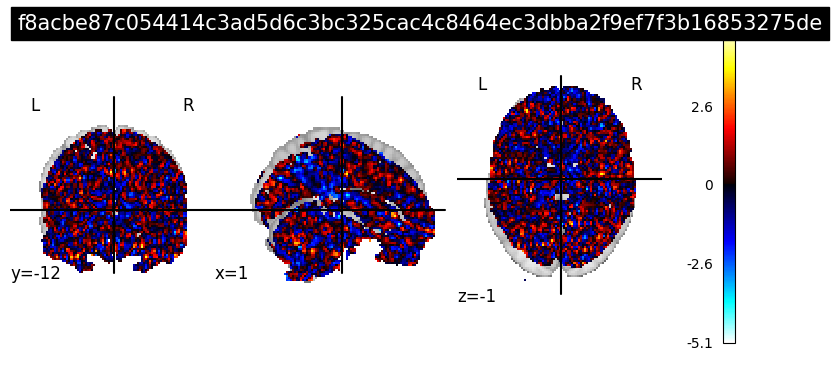

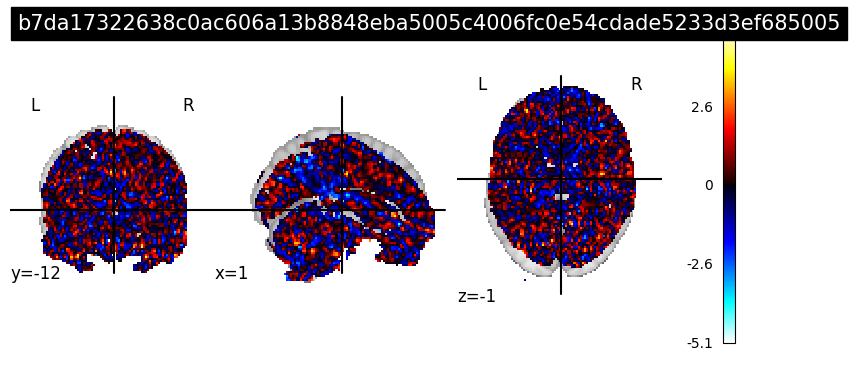

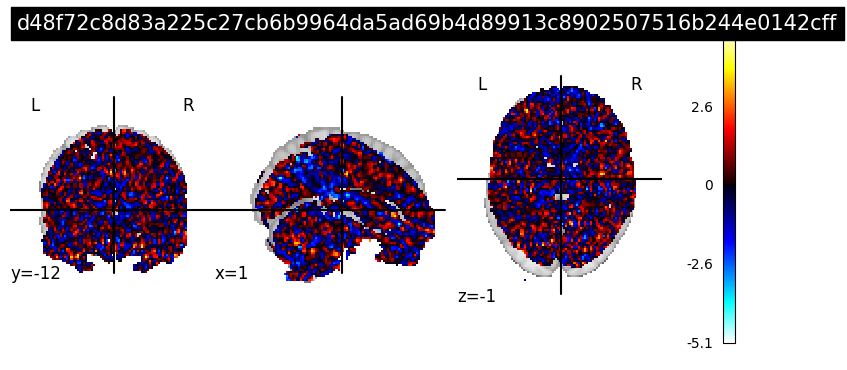

[from_ref] 3 best correlated maps


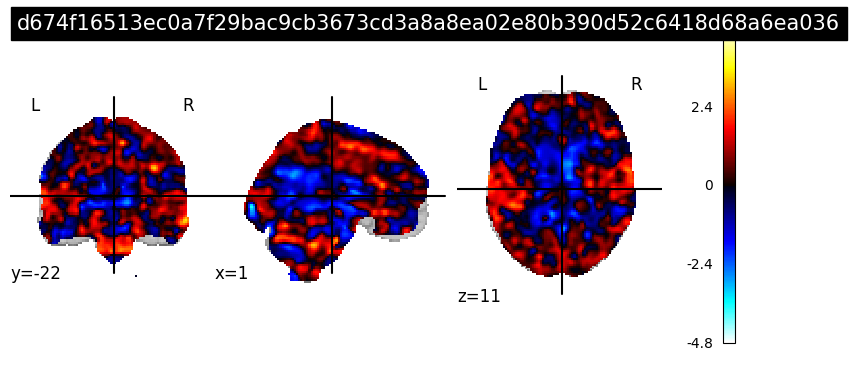

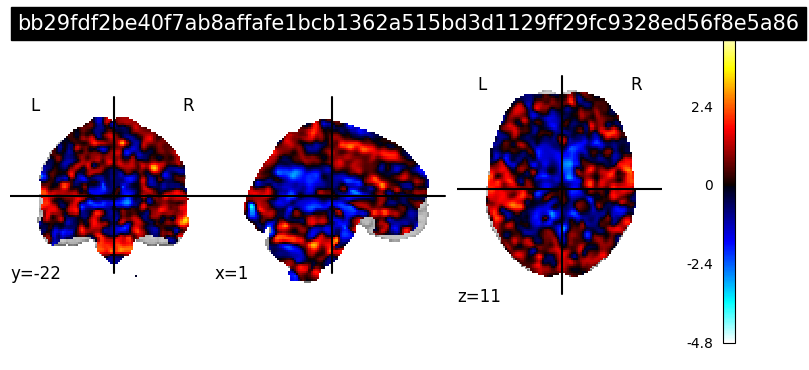

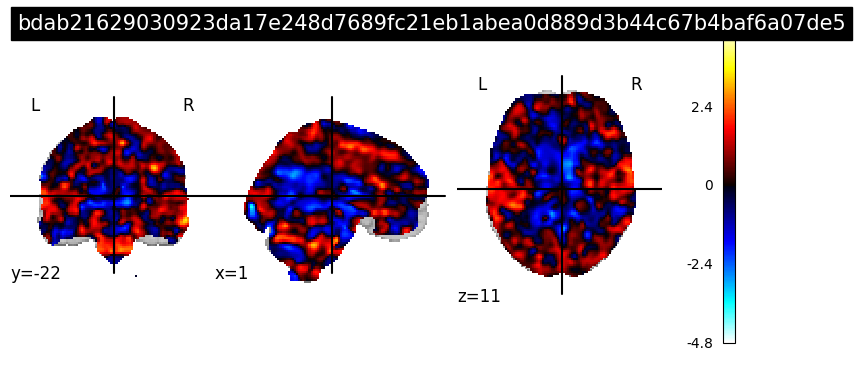

[from_mean] 3 worst correlated maps


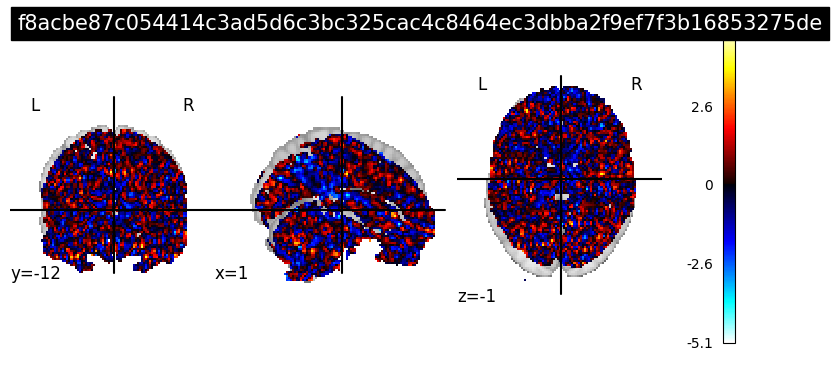

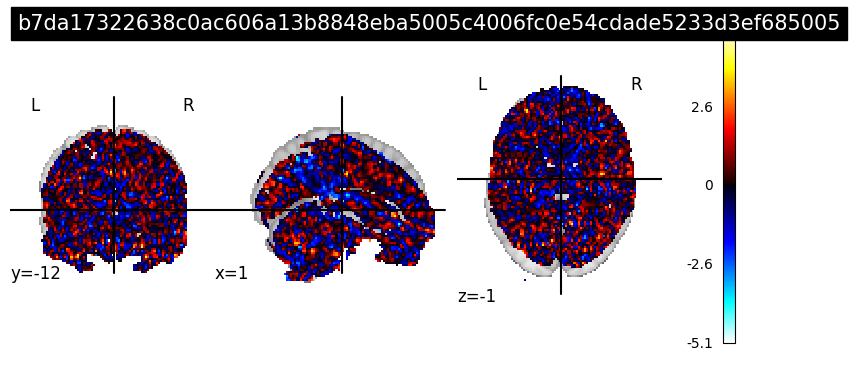

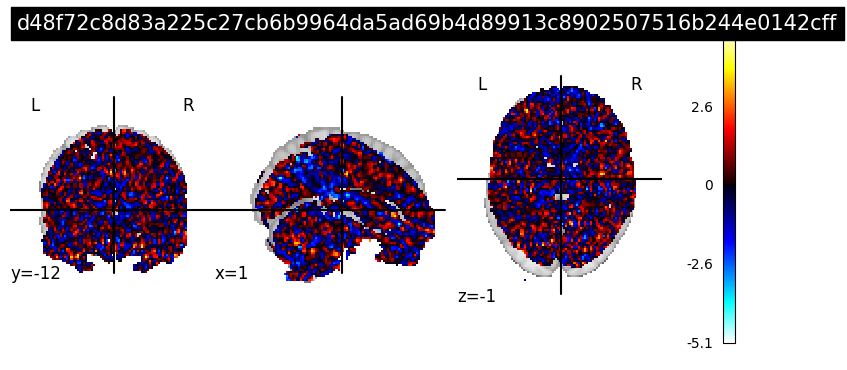

[from_mean] 3 best correlated maps


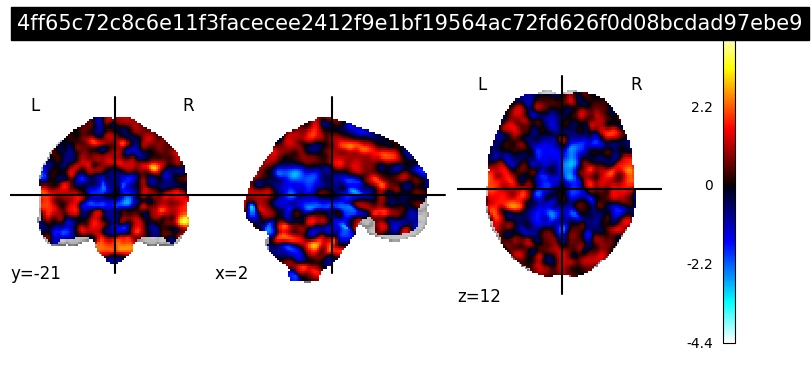

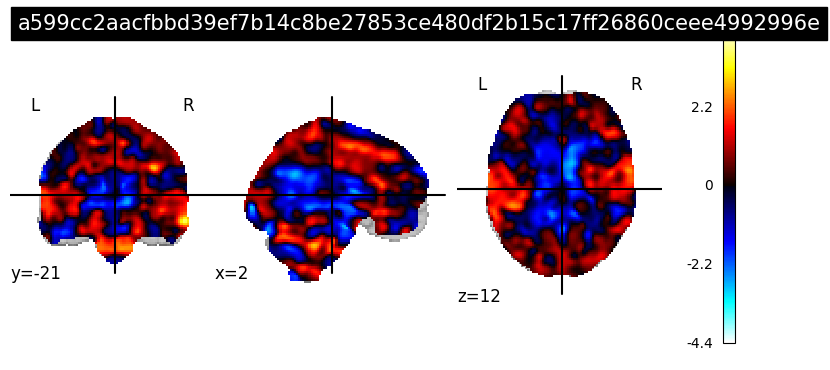

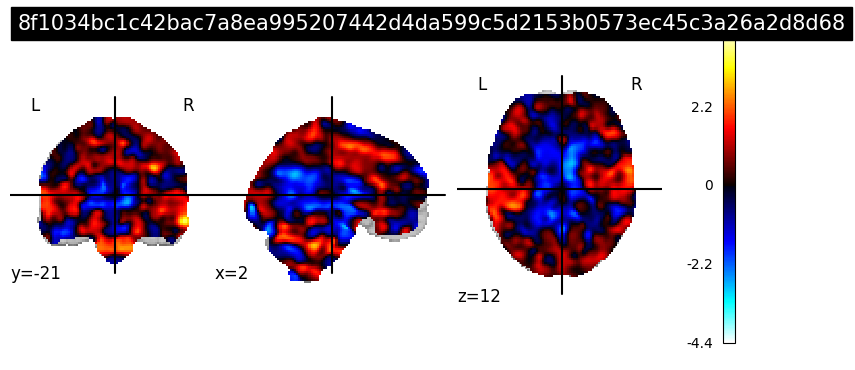

[mean_corr] 3 worst correlated maps


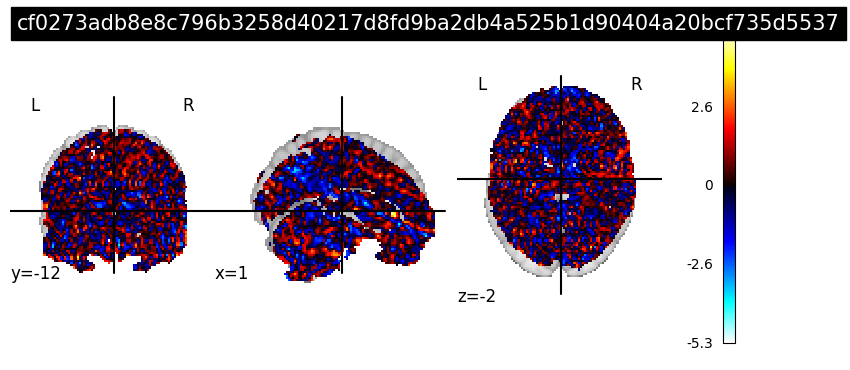

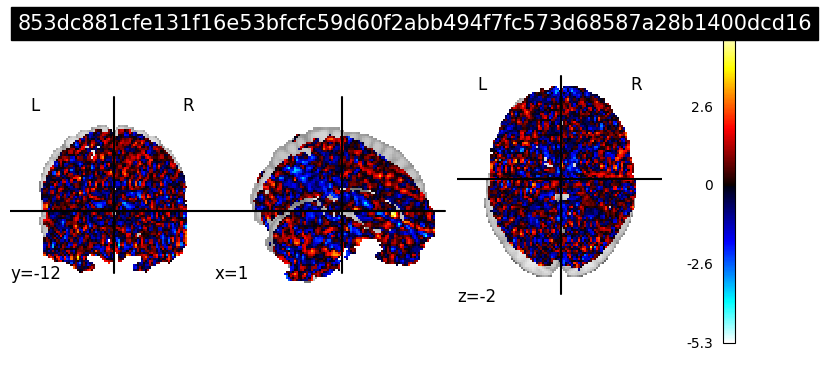

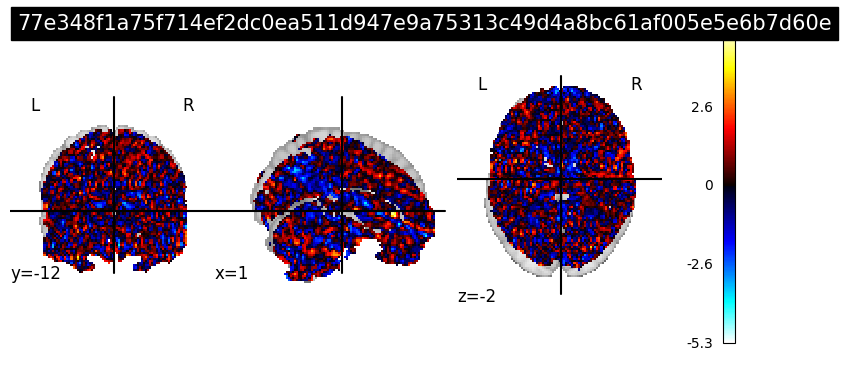

[mean_corr] 3 best correlated maps


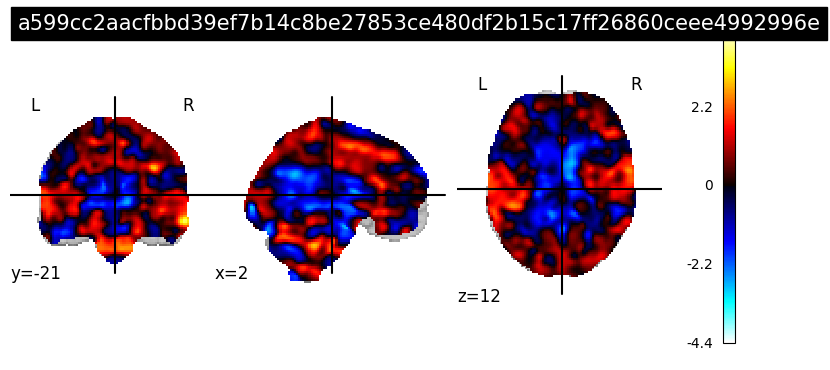

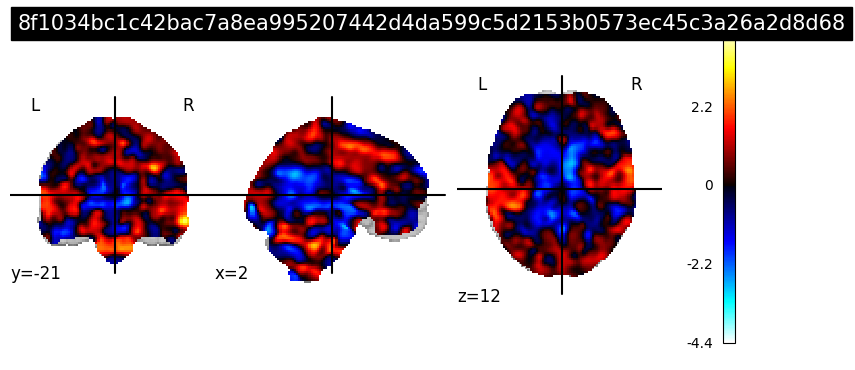

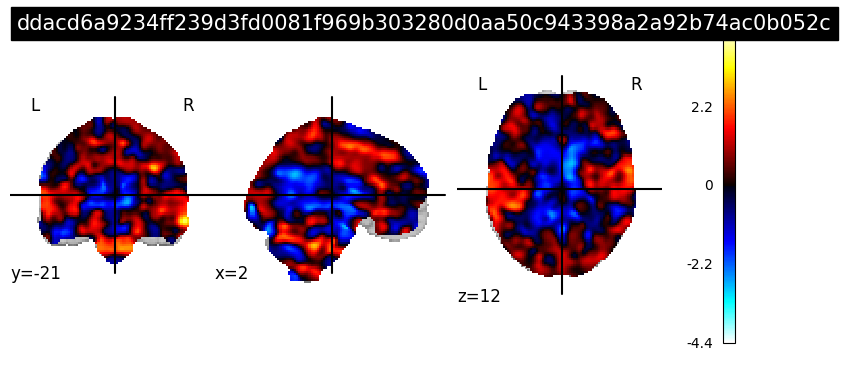

In [27]:
for ref in ['from_ref', 'from_mean', 'mean_corr']:
    print(f"[{ref}] 3 worst correlated maps")
    for conf_id in dataset.nsmallest(3, ref)['id']:
        img = nimg.load_img(os.path.join(basedir, conf_id, '_subject_id_01', 'result.nii'))
        plotting.plot_stat_map(img, title=conf_id)
    plt.show() 
    print(f"[{ref}] 3 best correlated maps")
    for conf_id in dataset.nlargest(3, ref)['id']:
        img = nimg.load_img(os.path.join(basedir, conf_id, '_subject_id_01', 'result.nii'))
        plotting.plot_stat_map(img, title=conf_id)
    plt.show() 

# Fit decision tree model for all metrics

In [28]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

results = []
feat_importances = []
for metric in corr_fields:
    X = dataset.drop(columns=ignored)
    y = dataset[metric]
    
    
    test_size=0.3
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    # Train model
    reg = tree.DecisionTreeRegressor(max_depth=4)
    reg.fit(X_train, y_train)
    
    dot_data = tree.export_graphviz(reg, out_file=None, 
                         feature_names=X_train.columns.values,  
                         filled=True, rounded=True,
                         special_characters=True)
    graph = graphviz.Source(dot_data)  
    graph.render(metric)
    
    # learning curve
    # Define the range of training sizes
    train_sizes = np.linspace(0.1, 1.0, 10)
    
    # Compute the learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        reg, X, y, train_sizes=train_sizes, cv=10, scoring='neg_mean_squared_error'
    )
     
    features = X.columns
    importances = reg.feature_importances_
    for i, feat in enumerate(features): 
        feat_importances.append((metric, feat, reg.feature_importances_[i]))

    results.append((metric, 
                  mean_absolute_error(y_test, reg.predict(X_test)),
                  mean_squared_error(y_test,reg.predict(X_test)), 
                  mean_absolute_percentage_error(y_test, reg.predict(X_test)),
                    np.mean(train_scores, axis=1),
                    np.std(train_scores, axis=1),
                    np.mean(test_scores, axis=1),
                    np.std(test_scores, axis=1)  
                    )
    )

In [29]:
results_df = pd.DataFrame(results, columns=['Metric', 'MAE',  'MSE', 'MAPE', 'train_mean', 'train_std', 'test_mean', 'test_std']).sort_values(by='MAPE', ascending=False)
results_df.head(13)

,Metric,MAE,MSE,MAPE,train_mean,train_std,test_mean,test_std
6,from_6363ceb4ad5221e2fd865e8ba9181032905c33814...,0.042499,0.003358,18.047865,"[-0.0031004966931476603, -0.003111548890382292...","[9.484538725274129e-05, 8.082575092621035e-05,...","[-0.005401694256879039, -0.0035149401796477435...","[0.001086632597131436, 0.0006502869135890608, ..."
7,from_2566dc31e9fbea6d892a21f56ecb62ff9df850705...,0.059555,0.007216,16.651872,"[-0.0058519090958982735, -0.007423442389881117...","[0.0010305508910842406, 0.0004690383330163526,...","[-0.012702097931363288, -0.008708424867467054,...","[0.003776754374219588, 0.001348237323477655, 0..."
3,from_1bd27c273e9f4d9eec9254015501cc8d1eeb109a6...,0.064655,0.007491,15.561154,"[-0.004946584363222524, -0.007909576949976254,...","[3.657270061173772e-05, 0.0010906692316179725,...","[-0.009929218740390787, -0.008489535686248287,...","[0.0014374243111271378, 0.0012159608799500441,..."
4,from_e2981f97fc870a8fc8a66d9a40c3cc8dcb21be746...,0.068272,0.009648,15.277273,"[-0.004792232733820812, -0.005868981001776476,...","[5.1288767520517236e-05, 0.0001354125899015630...","[-0.01027112609775636, -0.007929627996147846, ...","[0.0016844049682433705, 0.0010823606338307588,..."
10,from_5b935ba44056218711fe041d9e5000904a788b010...,0.063119,0.009203,14.444375,"[-0.0043736964542317736, -0.010004794729347875...","[0.0009664241027543177, 0.0004974877773519332,...","[-0.013192541983227354, -0.010160886088299048,...","[0.0030011356434580224, 0.0036128127910149198,..."
5,from_bdab21629030923da17e248d7689fc21eb1abea0d...,0.060334,0.006418,12.873312,"[-0.005353290349145586, -0.006246432307123841,...","[6.676601438029985e-05, 0.0003108642454731094,...","[-0.007245001806258818, -0.006534164162148122,...","[0.0009264429115871983, 0.0008452450423335411,..."
0,from_ref,0.061779,0.007129,12.824790,"[-0.005325541836116842, -0.006236156807673189,...","[5.387104119634415e-05, 0.00030623141406827084...","[-0.007239633240412088, -0.006530730086818063,...","[0.0010065589483276912, 0.0008422202776916912,..."
2,from_33210c8a5f0e3921b5074eb7a4abd82a5b4f6e7ac...,0.049026,0.004591,12.764911,"[-0.002029177383473569, -0.004124052539591827,...","[0.0003318379570909166, 0.00038299354124255434...","[-0.00602417108848406, -0.006319021272461006, ...","[0.0014241534903287622, 0.001228059596722186, ..."
9,from_c475f858fc2881ef01d1d4b705346000d23d56508...,0.053493,0.005561,12.033292,"[-0.005013497464105787, -0.006121942673000881,...","[7.158257881289316e-05, 0.00029544736505347736...","[-0.013096889406667422, -0.005987720388572202,...","[0.002689976768980455, 0.0010288863088261369, ..."
11,from_05a74cdcbd5faa976b866eec5a083de5e3945cc85...,0.048312,0.004262,11.842092,"[-0.0020091919622187643, -0.003692482288706795...","[0.0001809608967586283, 0.00024276156167088437...","[-0.006019277566857516, -0.006361280646429613,...","[0.0008446963985007276, 0.000889729589523465, ..."


In [30]:
importance_df = pd.DataFrame(feat_importances, columns=['Metric', 'Feature', 'Importance']).sort_values(by='Importance', ascending=False)
importance_df.head(10)

,Metric,Feature,Importance
419,from_e2981f97fc870a8fc8a66d9a40c3cc8dcb21be746...,coregistration/cost_function/normalised_cross_...,0.792924
329,from_1bd27c273e9f4d9eec9254015501cc8d1eeb109a6...,coregistration/cost_function/normalised_cross_...,0.788170
1049,from_05a74cdcbd5faa976b866eec5a083de5e3945cc85...,coregistration/cost_function/normalised_cross_...,0.770955
1139,mean_corr,coregistration/cost_function/normalised_cross_...,0.754814
59,from_ref,coregistration/cost_function/normalised_cross_...,0.754479
509,from_bdab21629030923da17e248d7689fc21eb1abea0d...,coregistration/cost_function/normalised_cross_...,0.752160
239,from_33210c8a5f0e3921b5074eb7a4abd82a5b4f6e7ac...,coregistration/cost_function/normalised_cross_...,0.739411
149,from_mean,coregistration/cost_function/normalised_cross_...,0.625476
779,from_6b4189bcd2f407a23e0ebc2d14de55529eaab1b0f...,coregistration/cost_function/normalised_cross_...,0.619111
689,from_2566dc31e9fbea6d892a21f56ecb62ff9df850705...,coregistration/cost_function/normalised_cross_...,0.598205


# Mean absolute percentage error per metric

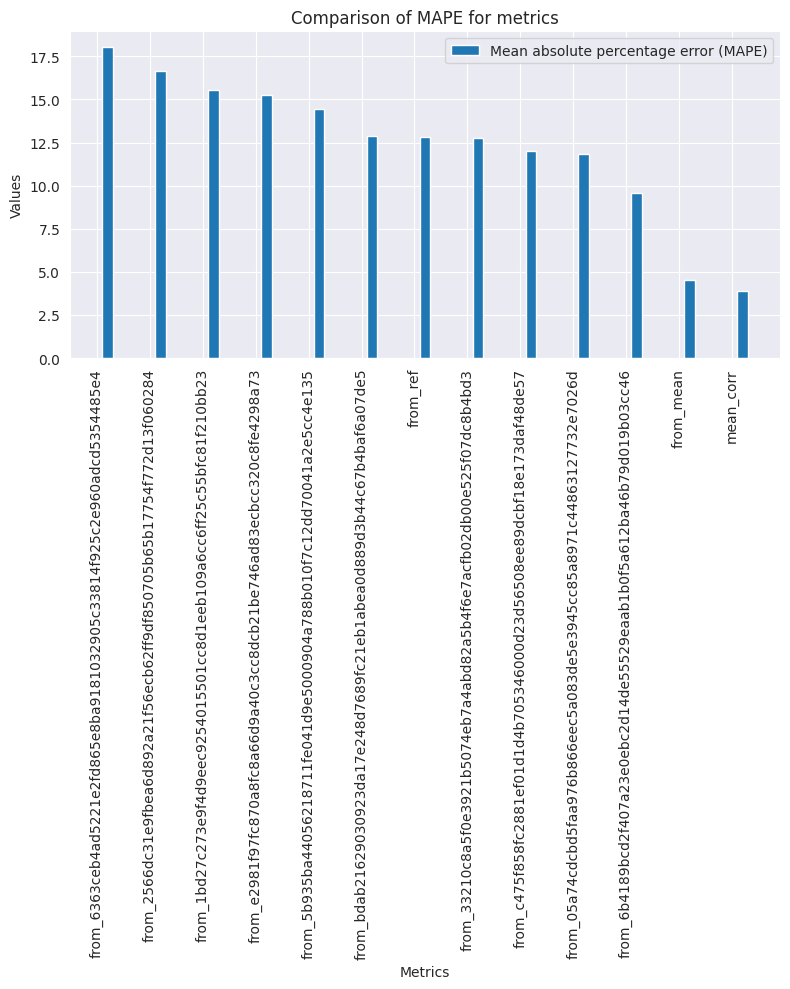

In [31]:
# Plotting
fig, ax = plt.subplots(figsize=(8, 10))
bar_width = 0.2
index = np.arange(len(results_df['Metric']))

# Plot bars for each metric
bar3 = ax.bar(index + 2 * bar_width, results_df['MAPE'], bar_width, label='Mean absolute percentage error (MAPE)')

# Adding labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Comparison of MAPE for metrics')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(results_df['Metric'])
ax.legend()

# Display the plot
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Learning curves of fitted models

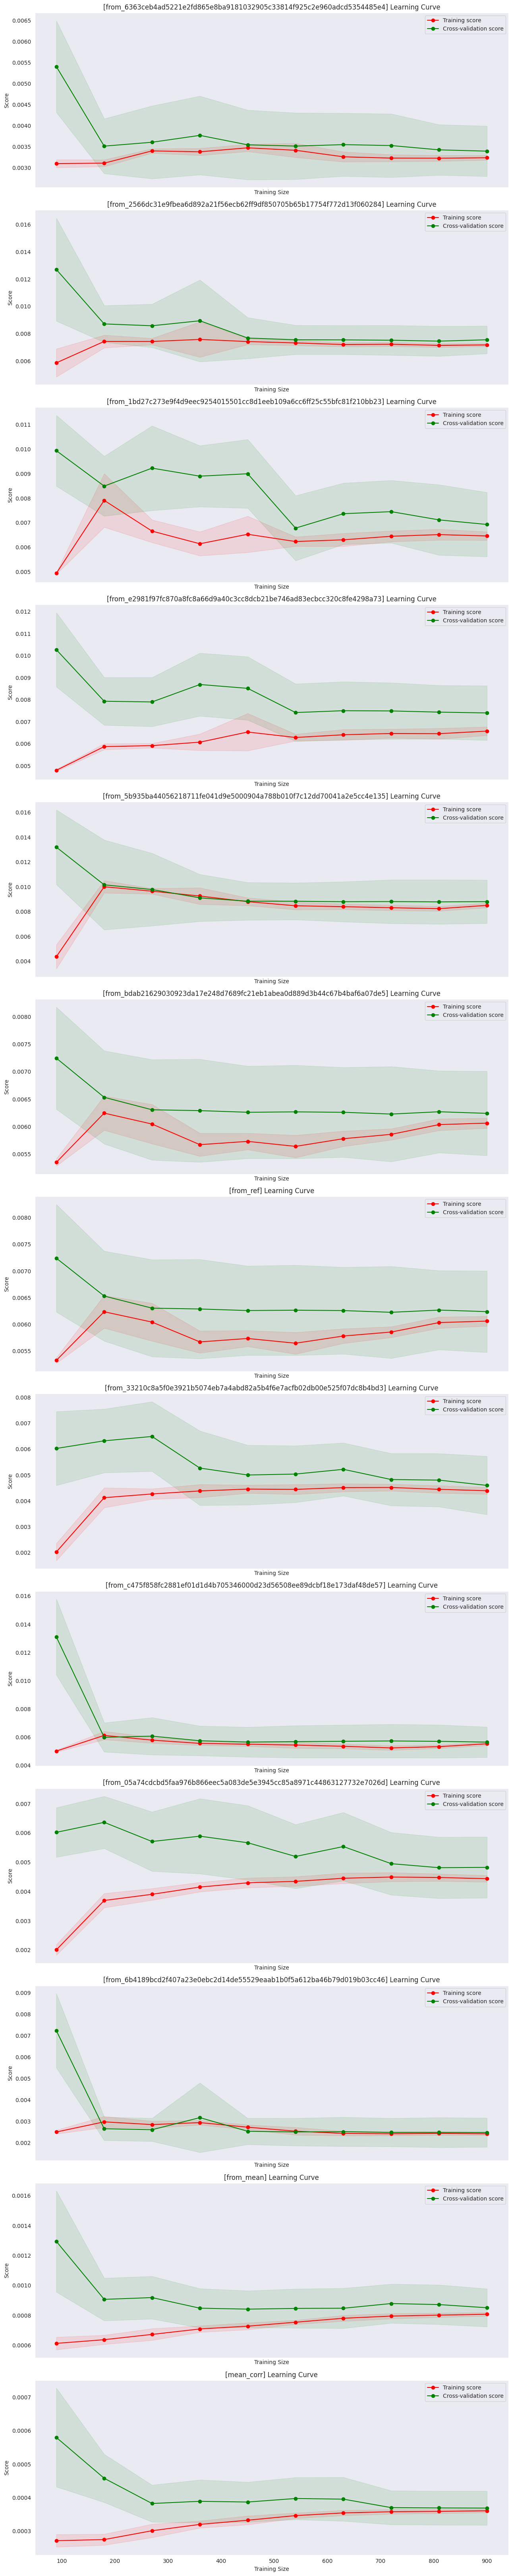

In [32]:
# Plotting
num_metrics = len(results_df)
fig, axes = plt.subplots(nrows=num_metrics, figsize=(num_metrics, num_metrics * 5), sharex=True)

for i, (index, row) in enumerate(results_df.iterrows()):
    ax = axes[i]
    ax.plot(train_sizes, -row['train_mean'], 'o-', color='r', label='Training score')
    ax.plot(train_sizes, -row['test_mean'], 'o-', color='g', label='Cross-validation score')
    ax.fill_between(train_sizes, -row['train_mean'] - row['train_std'], -row['train_mean'] + row['train_std'], alpha=0.1, color='r')
    ax.fill_between(train_sizes, -row['test_mean'] - row['test_std'], -row['test_mean'] + row['test_std'], alpha=0.1, color='g')
    ax.grid()
    ax.set_xlabel('Training Size')
    ax.set_ylabel('Score')
    ax.set_title(f'[{row["Metric"]}] Learning Curve')
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

# Correlations clustermap

In [33]:
correlations = pd.read_csv(corr_path, delimiter=';')
correlations.head()

,source,target,correlation
0,0a3e49ee189809ec52afbdb3c3c5083f090dcb0d218326...,0a3e49ee189809ec52afbdb3c3c5083f090dcb0d218326...,1.0
1,5c20760d37a8aa728efbbec6efc518da72c638cc88cdcd...,27682e60e19461bb32135219bee090029916238dfaf2f0...,1.0
2,3097a7dc41788499cf25575641e12f92017eaec464039b...,3d1d19d1d409196d5fa1185e4aa24f30701dd6cc448a06...,1.0
3,bbb3beabd28e8a1d0f553be543e76a38246c1416fbfb00...,bbb3beabd28e8a1d0f553be543e76a38246c1416fbfb00...,1.0
4,63bea197905677a189c165af71c8fc3933529cfb732832...,3097a7dc41788499cf25575641e12f92017eaec464039b...,1.0


/home/ymerel/fmri-feature-model/.venv/lib64/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ymerel/fmri-feature-model/.venv/lib64/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 2000x2000 with 0 Axes>

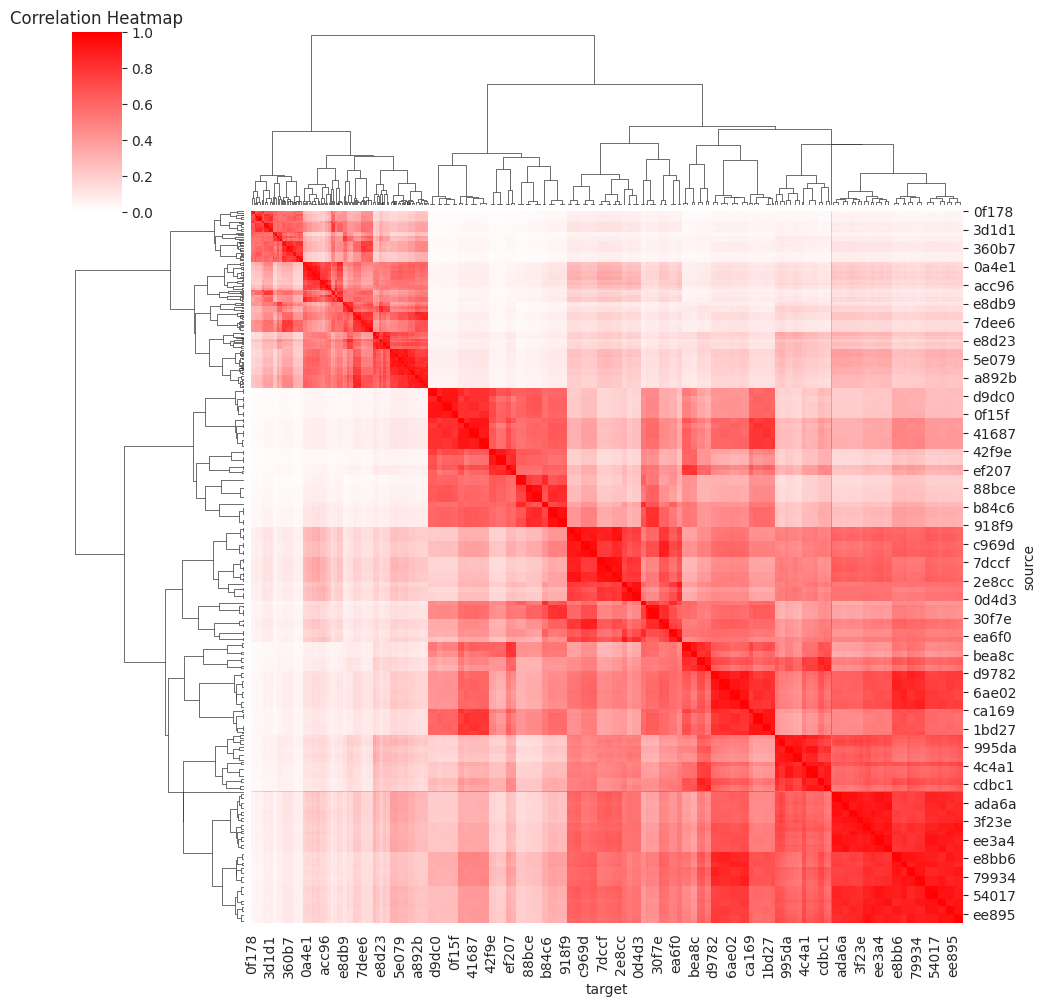

In [45]:
correlations['source'] = correlations['source'].str.slice(0, 5)
correlations['target'] = correlations['target'].str.slice(0, 5)
data = correlations.pivot(index='source', columns='target', values='correlation').fillna(1.0)
plt.figure(figsize=(20, 20))
cmap = LinearSegmentedColormap.from_list("red_cmap", ["#FFFFFF", "#FF0000"])
sb.clustermap(data, cmap=cmap, vmin=0, vmax=1)
plt.title('Correlation Heatmap')
plt.show()
